Neuron demo

In [1]:
import torch
import snntorch as snn
import matplotlib.pyplot as plt
from collections import namedtuple

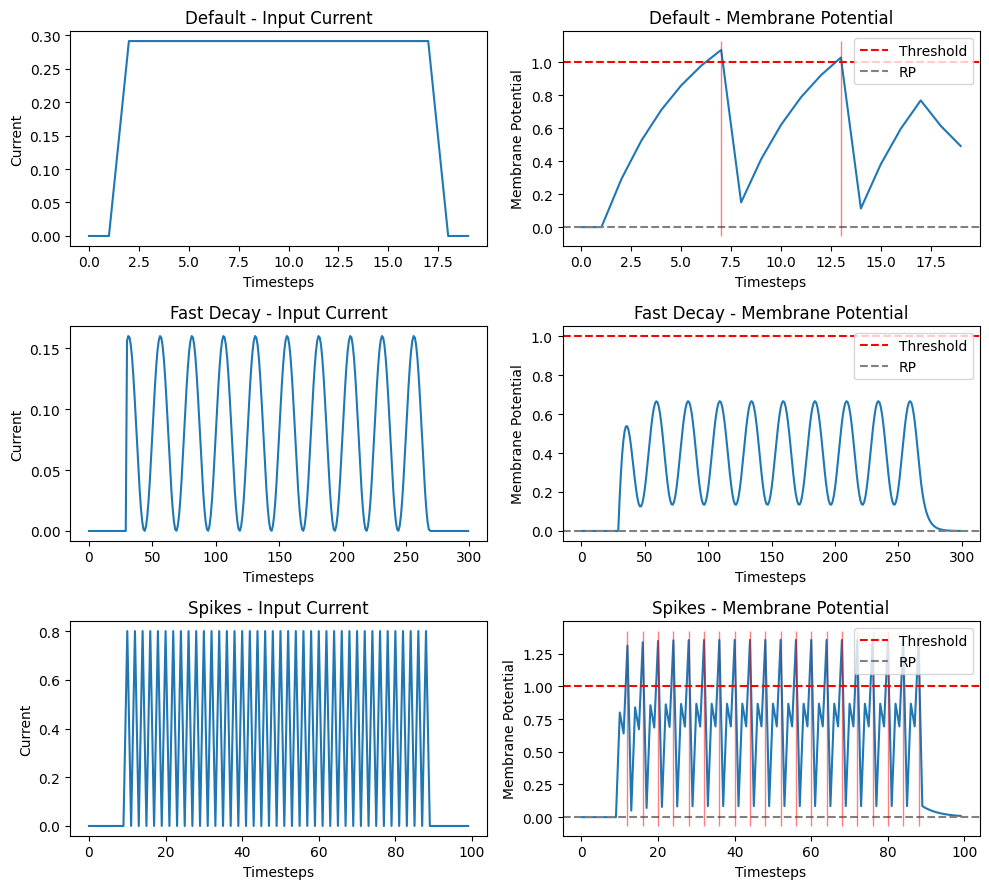

In [10]:
def generate_input(params):
    """
    Generates a time series input current based on the specified parameters. This is the input for the spiking neuron of our demo. 
    The function offers three different types of input currents: Sinusoidal, Continuous and Spiking. Sinussoidal currents follow 
    the shape of a sinus function and therefore have changing frequencies between two thresholds. Continuous currents send the same 
    input signal strength the entire time without any variation. Spiking currents send short impulses with pauses inbetween as inputs.

    Args:
        params: An object containing the following attributes:
            - steps (int): The number of time steps to generate.
            - input_type (str): The type of input current. 
              Options include:
              - 'sinusoidal': A sinusoidal current with a specified frequency and strength.
              - 'continuous': A constant current with a fixed strength.
              - 'spiking': A spiking current, where spikes occur at regular intervals 
                based on the specified frequency.
            - strength (float): The magnitude of the input current.
            - frequency (float): The frequency for 'sinusoidal' and 'spiking' input types.

    Returns:
        tuple:
            - time (torch.Tensor): A 1D tensor representing the time steps.
            - input_current (torch.Tensor): A 1D tensor representing the generated 
              input current over time.

    Raises:
        ValueError: If `input_type` is not one of 'sinusoidal', 'continuous', or 'spiking'.

    Notes:
        - The first and last 10% of the `input_current` will be set to zero, regardless
          of the input type, to allow for smooth transitions.
    """
    time = torch.arange(0, params.steps, 1)
    if params.input_type == "sinusoidal":
        sin_strength = params.strength / 2
        input_current = (
            sin_strength * torch.sin(2 * torch.pi * params.frequency * time)
            + sin_strength
        )
    elif params.input_type == "continuous":
        input_current = params.strength * torch.ones_like(time, dtype=torch.float32)
    elif params.input_type == "spiking":
        input_current = torch.zeros_like(time, dtype=torch.float32)

        # Calculate spike interval in steps (how many time steps between spikes)
        spike_interval = int(1 / params.frequency)

        # Set the spike values at the appropriate intervals
        for i in range(0, params.steps, spike_interval):
            input_current[i] = params.strength
    else:
        raise ValueError(
            "Invalid input_type. Choose 'sinusoidal', 'continuous' or 'spiking'."
        )
    zero_percentage = params.steps // 10
    input_current[:zero_percentage] = 0
    input_current[-zero_percentage:] = 0
    return time, input_current


def run_simulation(params):
    # Create the LIF neuron using snntorch
    neuron = snn.Leaky(
        beta=params.beta,
        threshold=params.v_threshold,
        reset_mechanism="subtract",
    )

    time, input_current = generate_input(params)

    membrane_potential = torch.zeros_like(time, dtype=torch.float32)
    spikes = torch.zeros_like(time, dtype=torch.float32)
    neuron.reset_mem()
    for i in range(len(time)):
        spk, mem = neuron(input_current[i])
        membrane_potential[i] = mem
        spikes[i] = spk

    return time, input_current, membrane_potential, spikes


def plot_results(results):
    num_sets = len(results)
    fig, axs = plt.subplots(num_sets, 2, figsize=(10, 3 * num_sets))

    # Handle single plot case
    if num_sets == 1:
        axs1 = axs[0]
        axs2 = axs[1]
        for i, (label, (time, input_current, membrane_potential, spikes)) in enumerate(
            results.items()
        ):
            # Input Current plot
            axs1.set_title(f"{label} - Input Current")
            axs1.plot(time, input_current)
            axs1.set_xlabel("Timesteps")
            axs1.set_ylabel("Current")

            # Membrane Potential plot
            axs2.set_title(f"{label} - Membrane Potential")
            axs2.plot(time, membrane_potential)
            axs2.axhline(
                y=param_sets[label].v_threshold,
                color="r",
                linestyle="--",
                label="Threshold",
            )
            axs2.set_xlabel("Timesteps")
            axs2.set_ylabel("Voltage")
            axs2.legend()

            # Add spike indicators
            spike_times = time[spikes.bool()]
            axs2.vlines(
                spike_times,
                axs2.get_ylim()[0],
                axs2.get_ylim()[1],
                color="r",
                linewidth=0.5,
                alpha=0.5,
            )

    else:
        for i, (label, (time, input_current, membrane_potential, spikes)) in enumerate(
            results.items()
        ):
            # Input Current plot
            axs[i, 0].set_title(f"{label} - Input Current")
            axs[i, 0].plot(input_current)
            axs[i, 0].set_xlabel("Timesteps")
            axs[i, 0].set_ylabel("Current")

            # Membrane Potential plot
            axs[i, 1].set_title(f"{label} - Membrane Potential")
            axs[i, 1].plot(membrane_potential)
            axs[i, 1].axhline(
                y=param_sets[label].v_threshold,
                color="r",
                linestyle="--",
                label="Threshold",
            )
            axs[i, 1].axhline(
                y=param_sets[label].v_reset, color="grey", linestyle="--", label="RP"
            )
            axs[i, 1].set_xlabel("Timesteps")
            axs[i, 1].set_ylabel("Membrane Potential")
            axs[i, 1].legend(loc="upper right")

            # Add spike indicators
            spike_times = time[spikes.bool()]
            axs[i, 1].vlines(
                spike_times,
                axs[i, 1].get_ylim()[0],
                axs[i, 1].get_ylim()[1],
                color="r",
                linewidth=1,
                alpha=0.5,
            )

    plt.tight_layout()
    plt.show()


# Define a named tuple for parameters
SimParams = namedtuple(
    "SimParams",
    [
        "beta",
        "v_threshold",
        "v_reset",
        "duration",
        "dt",
        "steps",
        "frequency",
        "strength",
        "input_type",
    ],
)

# Create a dictionary of parameter sets
param_sets = {
    "Default": SimParams(
        beta=0.8,
        v_threshold=1,
        v_reset=0.0,
        duration=10.0,
        dt=0.1,
        steps=20,
        frequency=0.1,
        strength=0.291,
        input_type="continuous",
    ),
    "Fast Decay": SimParams(
        beta=0.8, #when smaller -> more decay. Not above one!
        v_threshold=1,
        v_reset=0.0,
        duration=10.0,
        dt=0.1,
        steps=300,
        frequency=0.04,
        strength=0.16,
        input_type="sinusoidal",
    ),
    "Spikes": SimParams(
        beta=0.8,
        v_threshold=1,
        v_reset=0.0,
        duration=10.0,
        dt=0.1,
        steps=100,
        frequency=0.5,
        strength=0.8,
        input_type="spiking",
    ),
    # "Spikes2": SimParams(beta=0.85, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, steps=30, frequency=1, strength=0.21, input_type="spiking"),
    # "Slow Decay": SimParams(tau_m=20.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.1, strength=1.0, input_type="sinusoidal"),
    # "High Frequency": SimParams(tau_m=10.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.5, strength=1.0, input_type="sinusoidal"),
}

# Run simulations and store results
results = {}
for label, params in param_sets.items():
    results[label] = run_simulation(params)
# Plot the results
plot_results(results)